In [2]:
import numpy as np
import pyaudio
import pygame
import math
from matplotlib import pyplot as pl
import scipy as sp
import scipy.signal
import scipy.io.wavfile
from scipy.io.wavfile import write
from scipy.io.wavfile import read
import sounddevice as sd
import time
import ot
from tqdm import tqdm

pygame 2.1.2 (SDL 2.0.18, Python 3.8.3)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
CHUNK = 4096
nnft = CHUNK

RATE = 44100
Fe = RATE

In [16]:
def midi2freq(midi):
    return 2.0**((midi-69)*1./12)*440

def midi2ind(midi): #donne l'indice associé à la fréquence
    f = midi2freq(midi)
    j = int(f/freq_step)
    return j
    
def freq2midi(f):
    return (math.log(f/440,2)*12+69)

Musical notes are:  C5 E5 et G5
With the MIDI scale : 72 76 et 79

## Reading the piano file of the notes

Text(0.5, 1.0, 'Spectrum of midi 60')

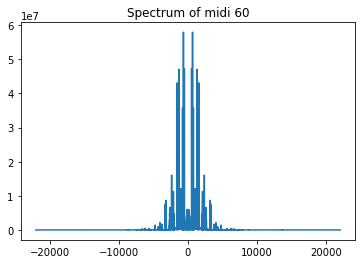

In [17]:
rate,data_1 = sp.io.wavfile.read("Do_Mi_Sol_C4.wav")
data = data_1[:,0]

e_fft = np.fft.fft(data) #ordonnées 
e_fft_pos = e_fft[:len(data)//2] #on prend les frequences positives
e_fft = np.fft.fftshift(e_fft) #pour ploter

freq = np.fft.fftfreq(len(data),1/rate) # fréquences 

freq_pos=freq[:len(freq)//2] #meme manip
freq = np.fft.fftshift(freq)

pl.plot(freq,np.abs(e_fft))
pl.title("Spectrum of midi 60")


In [18]:
data.shape

(121633,)

## Focusing on frequencies

0.36256607992896667

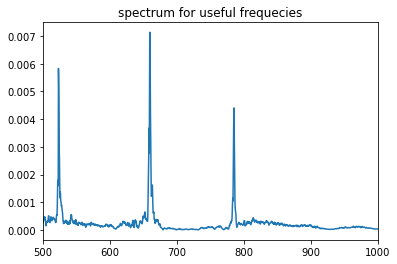

In [32]:
freq_step=rate/len(data) #ecart entre 2 fréquences consécutives

freq_pos=freq_pos[:int(CHUNK/freq_step)] #Chunk: freq maximale, écart de 0.43 entre chaque freq
e_fft_pos=e_fft_pos[:int(CHUNK/freq_step)] #v
e_fft_pos=np.abs(e_fft_pos)/np.sum(np.abs(e_fft_pos)) #normalisation
pl.plot(freq_pos,e_fft_pos)
pl.title("spectrum for useful frequecies")
pl.xlim(500,1000)
freq_step

We also generate a pure dirac of frequency to be sure that a single note is transported to the same one

array([0., 0., 0., ..., 0., 0., 0.])

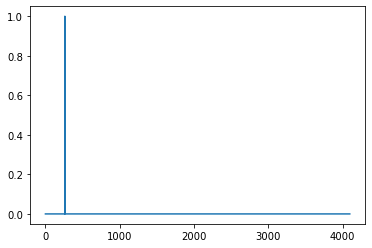

In [20]:
dirac60 = np.zeros((len(freq_pos,)))
frequence_midi60 = midi2freq(60)
dirac60[int(frequence_midi60/freq_step)]+=1
pl.plot(freq_pos,dirac60)

dirac60

In [21]:
CHUNK = 4096
nfft=CHUNK

freq_step=rate/len(data) 
nb_freq=int(CHUNK/freq_step)

RATE = 44100
Fe = RATE

midi_start=46
midi_end=84


midi_notes=[0] # add noise mote index 0
midi_notes.extend(list(range(midi_start,midi_end+1)))
#midi_notes[0]=60
nb_midi=len(midi_notes)

print("nfft: "+str(nfft))
print("rate: "+str(rate))
print("nbr_freq= CHUNK/freq_step: "+str(CHUNK/freq_step))
print("freq_step: "+str(freq_step))

nfft: 4096
rate: 44100
nbr_freq= CHUNK/freq_step: 11297.250975056688
freq_step: 0.36256607992896667


### Optimal transport Matrix Cost for OST

In [23]:
def get_matrix_cost(midi_notes,Fe,nfft,freq_pos,nz=1e4,eps=10):
    """
    returns the optimal transport loss matrix from a list of midi notes (interger indexes)
    """
    nbnotes=len(midi_notes)
    
    res=np.zeros((int(nfft/freq_step),nbnotes)) #matrix
    
    #f=np.fft.fftfreq(nfft,1.0/Fe)[:int(nfft/freq_step)] #liste des fréquences
    
    f=freq_pos
    f_note=[midi2freq(n) for n in midi_notes] # midi converties en frequences (il mettait 60 avant??)
    
    for i in range(nbnotes):
        m=np.zeros((int(nfft/freq_step),))
        if midi_notes[i]==0:
            m[:]=nz
        else:
            nmax=int(f.max()/f_note[i])
            m[:]=np.inf
            for j in range(1,nmax+1):
                m=np.minimum(m,(j*f_note[i]-f)**2+j*eps)
        res[:,i]=m #on regle les colonnes : ie on gere le cout pour une note midi
    return res,f

In [24]:
eps=10
COST=get_matrix_cost(midi_notes,Fe,nfft,freq_pos,eps=eps)[0]

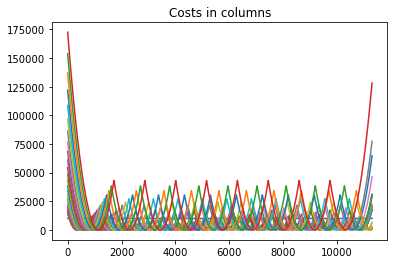

In [25]:
for i in range(24):
    pl.plot(COST[:,i])
pl.title("Costs in columns")
pl.show()

In [26]:
K=84-46+2 
W=np.zeros((nb_freq,K)) #W will be the dictionnary matric with a dirac in each column on the fundamental frequency
dict_midi_to_ind={}
for counter,midi in enumerate(range (45,85)):
    m = np.zeros(nb_freq)
    j = midi2ind(midi)
    dict_midi_to_ind[midi]=j
    m[j]=1
    W[:,counter]=m
dict_ind_to_midi = {v:k for k,v in dict_midi_to_ind.items()}
S=list(dict_ind_to_midi.keys())


In [27]:
L = np.zeros((nb_freq,K))

for i in range(nb_freq):
    k = np.argmin(COST[i,:])
    L[i,k]=1


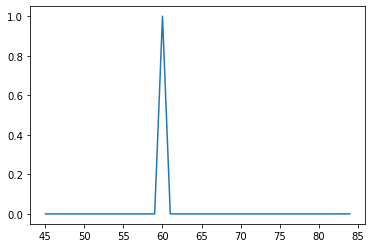

In [28]:
H= np.dot(L.T,dirac60)
X = list(range(45,85))
pl.plot(X,H)

Great : the OST recognizes the single MIDI 60 

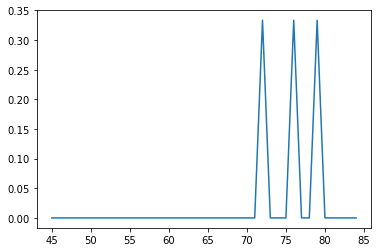

In [31]:
H_True = np.zeros(85-45)
H_True[72-45]=1/3
H_True[76-45]=1/3
H_True[79-45]=1/3

X = list(range(45,85))
pl.plot(X,H_True)

Great : the OST recognizes the single pure notes

In [33]:
%%time
H_OST= np.dot(L.T,e_fft_pos)


CPU times: user 4.68 ms, sys: 1.65 ms, total: 6.33 ms
Wall time: 1.3 ms


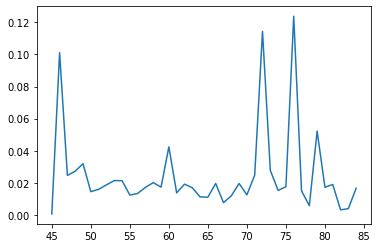

In [34]:
pl.plot(X,H_OST)

The OST recognizes MIDI 72 and 76 well, 79 is also recognized be the MIDI 47 appears too. 


In [35]:
np.argmax(np.dot(L.T,e_fft_pos))

31

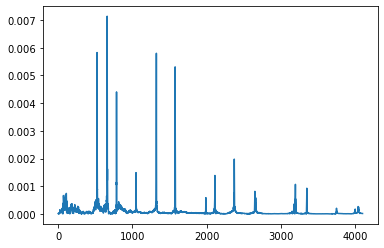

In [36]:
pl.plot(freq_pos,e_fft_pos)

# OST_E : with entropy regularization

With the entrpoy there is a $\lambda$ for the regularisation. We set the $\lambda$ with the function to minimize the error.


In [37]:
def unmix_plan_entrop(M,lambd):
    """
    returns the rpe compute L plan for entropic regularized OST

    """
    E=np.exp(-M/lambd/M.max())
    return E*1./(E.sum(1).reshape((M.shape[0],1)))

def L_e(lambd):
    return(unmix_plan_entrop(COST,lambd))
lambd= 0.00002
L_E = L_e(lambd)

In [38]:
%%time
H_OST_E= np.dot(L_E.T,e_fft_pos)

CPU times: user 3.33 ms, sys: 818 µs, total: 4.15 ms
Wall time: 893 µs


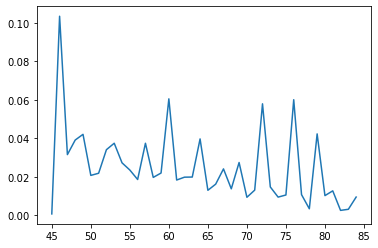

In [39]:
pl.plot(X,H_OST_E)

In [40]:
def choix_lambda(L_E,e_fft_pos):
    lambd_0=0.00002
    lambd_1=0.01
    for i in range(20):
        H_OST_E_0= np.dot(L_e(lambd_0).T,e_fft_pos)
        err_0 = np.sum(np.abs(H_True-H_OST_E_0))
        H_OST_E_1= np.dot(L_e(lambd_1).T,e_fft_pos)
        err_1 = np.sum(np.abs(H_True-H_OST_E_1))
        
        if err_0<err_1:
            lambd_1=(lambd_1+lambd_0)/2
        else:
            lambd_0=(lambd_1+lambd_0)/2
        print(err_1)
    return(lambd_0)
        
    

In [41]:
choix_lambda(L_E,e_fft_pos)

1.906661062747308
1.902474143404258
1.8901367721421234
1.8728806292566942
1.8533695655933906
1.834299430953739
1.8183280439160867
1.799917499543766
1.7755295164884253
1.747884305719582
1.7228211516684544
1.704432080728405
1.6929268052791318
1.686424638550001
1.6829579672756836
1.681166658899404
1.680255962471311
1.6797967824065756
1.6795662253278714
1.6794507038805093


2e-05

Unfortunately the effect of $\lambda$ seems to not be useful , as the error decreases when lambda decreases.This method is less useful than simple OST.

# OST G

Different algorithm but same method with $\lambda$

In [43]:
def calc_L(C):
    L = np.zeros((nb_freq,K))

    for i in range(nb_freq):
        k = np.argmin(C[i,:])
        L[i,k]=1
    return L

In [44]:
def OST_g(lambda_g,C,nbiter,v):
    R_iter = np.zeros(C.shape)
    C_iter = np.copy(C)
    for i in range(nbiter):
        C_iter=C_iter+R_iter
        L_iter=calc_L(C_iter)
        T_iter = np.diag(v)@L_iter
        h_iter=L_iter.T@v
        for k in range(T_iter.shape[1]):
            R_iter[:,k]=0.5*math.sqrt(np.linalg.norm(T_iter[:,k],ord=1))
    return h_iter


In [45]:
def choix_lambda(COST,e_fft_pos):
    lambd_0=0.1
    lambd_1=10000
    for i in range(5):
        H_OST_G_0= OST_g(lambd_0,COST,5,e_fft_pos)
        err_0 = np.sum(np.abs(H_True-H_OST_G_0))
        H_OST_G_1= OST_g(lambd_1,COST,5,e_fft_pos)
        err_1 = np.sum(np.abs(H_True-H_OST_G_1))
        
        if err_0<err_1:
            lambd_1=(lambd_1+lambd_0)/2
            print("lambda1 : ")
            print(lambd_1)
            print("erreur : ")
            print(err_0)
        else:
            lambd_0=(lambd_1+lambd_0)/2
            print("lambda0 : ")
            print(lambd_0)
            print("erreur : ")
            print(err_1)
        
    return(lambd_0)
        

In [46]:
%%time
H_OST_G=OST_g(1000,COST,5,e_fft_pos)

CPU times: user 6.08 s, sys: 2.44 s, total: 8.52 s
Wall time: 2.49 s


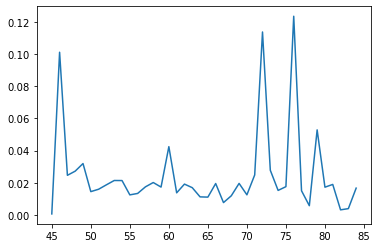

In [47]:
pl.plot(range(45,85),H_OST_G)

The algorithm seems to be as efficient as simple OST.

# Récapitulatif: 
    

In [48]:
print("Pour OST simple : ")
print(" ")
print("Temps : 1.25 ms")
print("Erreur L1 : " +str(np.sum(np.abs(H_True-H_OST))))

Pour OST simple : 
 
Temps : 1.25 ms
Erreur L1 : 1.4190477379063693


In [49]:
print("Pour OST E : ")
print(" ")
print("Temps : 673 µs")
print("Erreur L1 : " +str(np.sum(np.abs(H_True-H_OST_E))))

Pour OST E : 
 
Temps : 673 µs
Erreur L1 : 1.6793350200554895


In [50]:
print("Pour OST G : ")
print(" ")
print("Temps : 2.07 s")
print("Erreur L1 : " +str(np.sum(np.abs(H_True-H_OST_G))))

Pour OST G : 
 
Temps : 2.07 s
Erreur L1 : 1.4196408827653935


As we saw, OST and OST G have the same errors. 